In [1]:
import re
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1" #set to your prefered device ID
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from VLMAdapter import PrismVLMTextEncoder
from flux_custom import FluxCustomPipeline

def choose_article(phrase):
    first_word = re.findall(r'\b\w+\b', phrase)[0]
    return 'An' if first_word[0].lower() in 'aeiou' else 'A'

cache_dir = "XXXXXXXXXXXXX" # Set your prefered HuggingFace cache dir, make sure you have atleast 40GB of storage spacee 

pipe = FluxCustomPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype = torch.bfloat16, cache_dir = cache_dir).to('cuda')
prism = PrismVLMTextEncoder("openai/clip-vit-large-patch14", adapter_type="identity")

concepts_for_vectors = ["Doctor","Engineer","Teacher","Scientist","Chef","Police Officer","CEO","Artist","Construction Worker"] # to compute the attribute vectors
race_attrs = ["white", "black", "asian", "indian"]
gender_attrs = ['male', 'female']

def create_semantic_vector_lookup(professions, races, genders, encoder):
    prompts = {}
    for prof in professions:
        prompts[prof] = f"a photo portrait of {choose_article(prof)} {prof}"

        for race in races:
            prompts[f'{race} {prof}'] = f"a photo portrait of {choose_article(race)} {race} {prof}"
        for gender in genders:
            prompts[f'{gender} {prof}'] = f"a photo portrait of {choose_article(gender)} {gender} {prof}"
        for race in races:
            for gender in genders:
                prompts[f'{race} {gender} {prof}'] = f"a photo portrait of {choose_article(race)} {race} {gender} {prof}"

    # 2. Calculate embeddings for all prompts
    print("\nCalculating embeddings for all prompts...")
    embeddings = {}
    print(prompts)
    for key, prompt in tqdm(prompts.items(), desc="Encoding Prompts"):
        embeddings[key] = encoder([prompt])

    # 3. Calculate and average the semantic vectors across all professions
    semantic_vectors = {}
    intersection = [f"{race} {gender}" for race in races for gender in genders]
    all_attributes = races + genders + intersection

    semantic_vectors = {}

    for attr in tqdm(all_attributes):
        semantic_vectors[attr] = {}
        for prof in professions:
            base_embedding = embeddings[prof]
            attr_embedding = embeddings[f"{attr} {prof}"]
            diff_vector = attr_embedding - base_embedding
            semantic_vectors[attr][prof] = diff_vector

    print("\n--- Semantic Vector Lookup Table Created Successfully ---")
    return semantic_vectors


def average_semantic_attribute_vectors(semantic_vectors):
    averages = {}
    for k in semantic_vectors.keys():
        embs = torch.cat([semantic_vectors[k][p] for p in semantic_vectors[k].keys()]).mean(dim = 0)
        averages[k] = embs
    return averages

semantic_vectors = create_semantic_vector_lookup(concepts_for_vectors, race_attrs, gender_attrs, prism)
semantic_averages = average_semantic_attribute_vectors(semantic_vectors) # Look up table


/data/venkatesh/anaconda3/envs/EA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.76it/s]


model loaded
Overriding the given embedding dim to the actual hidden size 768 of the text_encoder for compatibility

Calculating embeddings for all prompts...
{'Doctor': 'a photo portrait of A Doctor', 'white Doctor': 'a photo portrait of A white Doctor', 'black Doctor': 'a photo portrait of A black Doctor', 'asian Doctor': 'a photo portrait of An asian Doctor', 'indian Doctor': 'a photo portrait of An indian Doctor', 'male Doctor': 'a photo portrait of A male Doctor', 'female Doctor': 'a photo portrait of A female Doctor', 'white male Doctor': 'a photo portrait of A white male Doctor', 'white female Doctor': 'a photo portrait of A white female Doctor', 'black male Doctor': 'a photo portrait of A black male Doctor', 'black female Doctor': 'a photo portrait of A black female Doctor', 'asian male Doctor': 'a photo portrait of An asian male Doctor', 'asian female Doctor': 'a photo portrait of An asian female Doctor', 'indian male Doctor': 'a photo portrait of An indian male Doctor', 'indi

100%|██████████| 14/14 [00:00<00:00, 18623.61it/s]


--- Semantic Vector Lookup Table Created Successfully ---


#### Default Model

  8%|▊         | 2/26 [00:00<00:06,  3.92it/s]

100%|██████████| 26/26 [00:08<00:00,  3.22it/s]


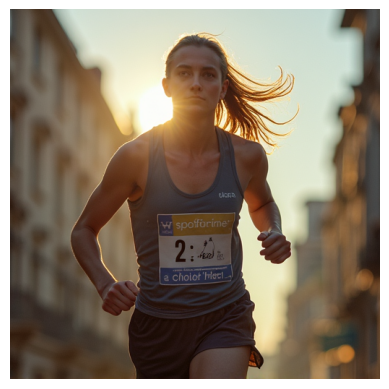

In [ ]:
prompt = "a photo of a person running a marathon"
prompt_embed = prism([prompt])
seed_value = 786
generator = torch.Generator(device = "cuda").manual_seed(seed_value)
image, _ = pipe.generate_with_custom_embedding(prompt_embed, num_inference_steps=26, guidance_scale=3.5, height=512, width=512, generator=generator)
plt.imshow(image)
plt.axis("off")
plt.show()

### Embedding Arithmetic

100%|██████████| 26/26 [00:08<00:00,  3.08it/s]


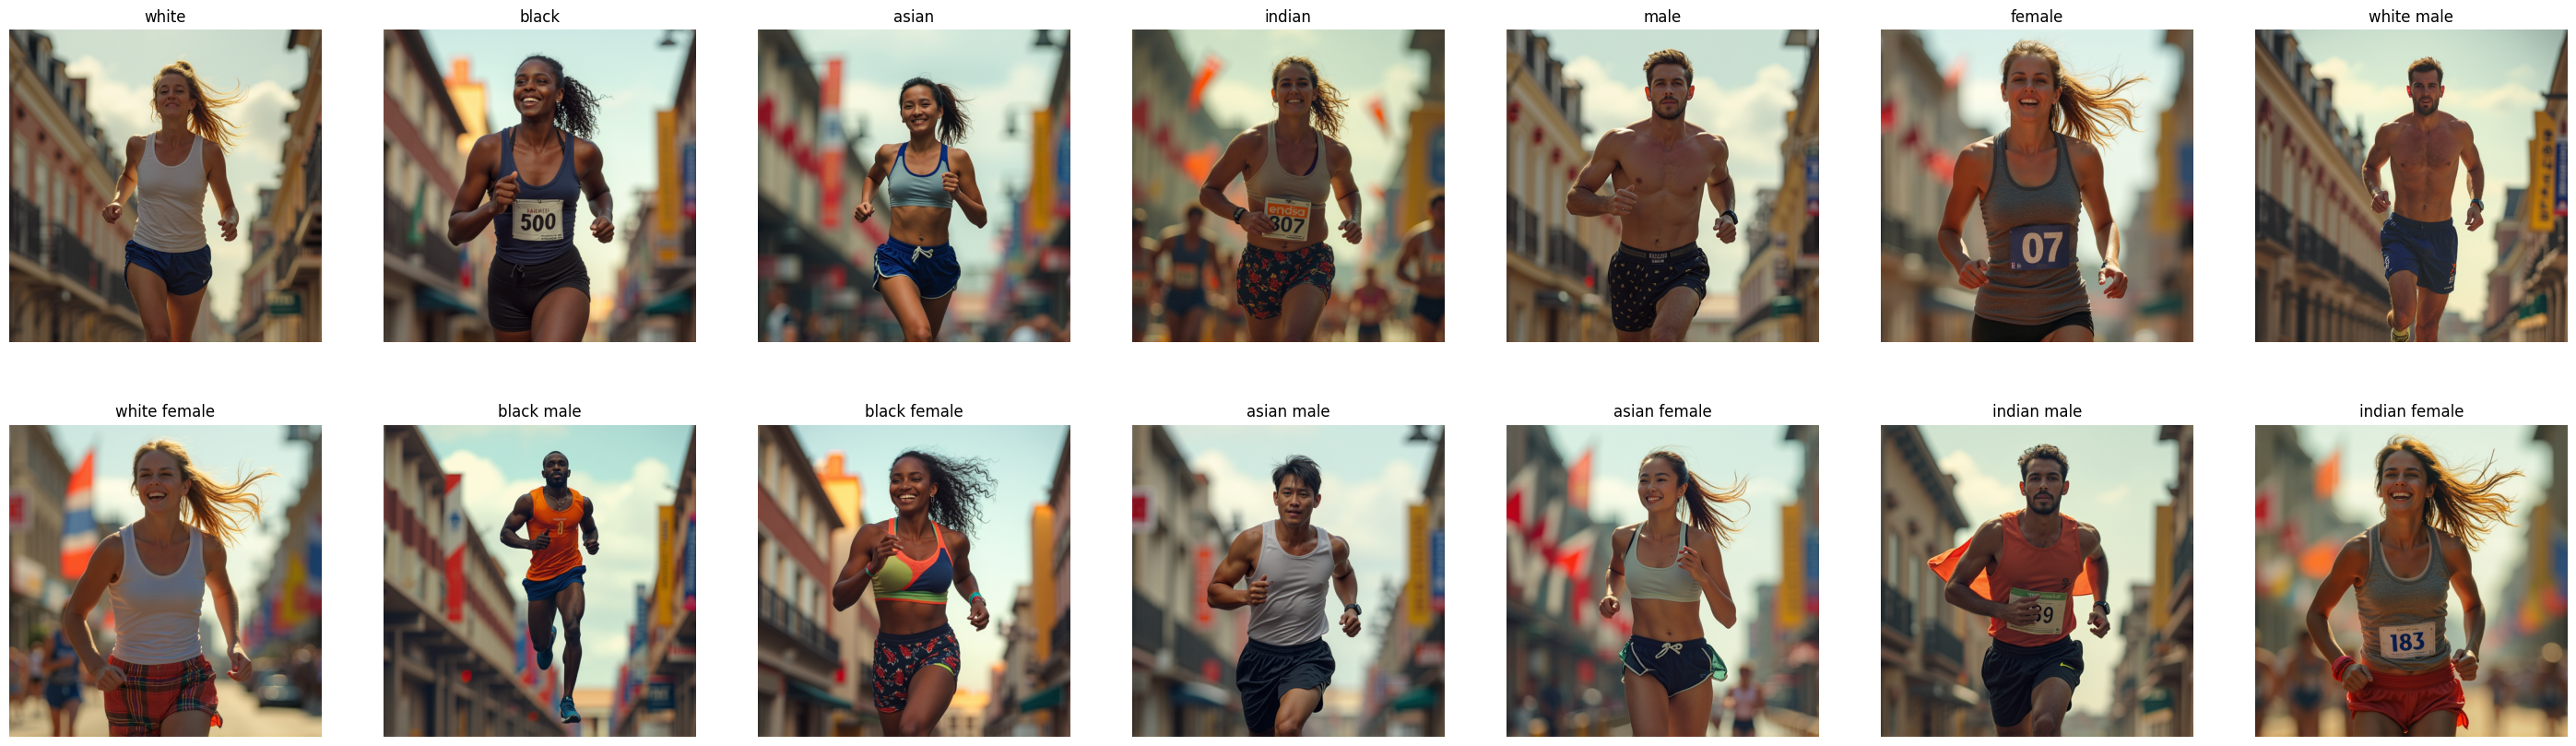

In [ ]:
alpha = 1.25
fig, ax = plt.subplots(nrows = 2, ncols = 7, figsize = (35.8,10.2))
ax = ax.flatten()
for i, attr in enumerate(semantic_averages.keys()):
    composed = prompt_embed + alpha * semantic_averages[attr] # Perform Composition
    generator = torch.Generator(device = "cuda").manual_seed(seed_value)
    image, _ = pipe.generate_with_custom_embedding(composed, num_inference_steps=26, guidance_scale=3.5, height=512, width=512, generator=generator)
    ax[i].imshow(image)
    ax[i].set_axis_off()
    ax[i].set_title(attr)
